In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import intake,yaml
import intake_esm
from scipy import special
import keras
from keras.models import Model
from keras.layers import Dense, Input

In [2]:
def latest_version(cat):
    """
    input
    cat: esmdatastore
    output
    esmdatastore with latest DRS versions
    """
    latest_cat = cat.df.sort_values(by=['version','path']).drop_duplicates(['temporal_subset','source_id','table_id',
                                               'institution_id','variable_id','member_id',
                                               'grid_label','experiment_id'],keep='last')
    return latest_cat

In [3]:
def chunk_time(ds):
    if 'time' in ds.dims:
        ds = ds.chunk({'time':1})
    return ds

In [4]:
# Necessary for creating a common time axis for all models
# We want to create a common time axis so there will be no gaps when plotting the results 

def fix_time(ds):
    """ force calendar to noleap"""
    import xarray as xr
    
    if "time" not in ds.dims:
        return ds
    
    if ("calendar" not in ds["time"].attrs): 
        ds["time"].attrs.update({"calendar": "noleap"})
        
    if ds["time"].attrs["calendar"] not in ["noleap", "NOLEAP", "365_day"]:
        ds["time"].attrs.update({"calendar": "noleap"})
        
    ds = xr.decode_cf(ds)
    return ds

In [5]:
def pp_enso(ds):
    ds = ds.copy()   #the wrapper function makes a copy of the ds and works from this
    #ds = rename_cmip6(ds)
    ds = fix_time(ds)
    #ds = fix_units(ds)
    #ds = correct_units(ds)
    return ds

In [6]:
#col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
col_url = "https://raw.githubusercontent.com/aradhakrishnanGFDL/gfdl-aws-analysis/master/esm-collection-spec-examples/esgf-world.json"
col = intake.open_esm_datastore(col_url)
esmcol_data = col.esmcol_data

In [7]:
model_name = 'CNRM-CM6-1'

In [8]:
#mlotst, tos,uo,vo

In [9]:
#tos_ sea surface temperature
#area cello
#ofx ocean fixed
#omon  ocean monthly average 

In [10]:

query_Omon_tos = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 table_id=['Omon'],
                 member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id=model_name,
                 grid_label=['gn'],
                 variable_id=["tos"])
query_Ofx = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 table_id=['Ofx'],
               member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id=model_name,
                 grid_label=['gn'],
                 variable_id=["areacello"])

In [11]:
cat_Omon_tos = col.search(**query_Omon_tos)
cat_Omon_tos_lat = latest_version(cat_Omon_tos)

cat_Omon_tos_latest = intake.open_esm_datastore(cat_Omon_tos_lat,esmcol_data=esmcol_data)

In [12]:
cat_Omon_tos_latest.df

,project,institution_id,source_id,experiment_id,frequency,modeling_realm,table_id,member_id,grid_label,variable_id,temporal_subset,version,path
0,CMIP6,CNRM-CERFACS,CNRM-CM6-1,1pctCO2,mon,ocean,Omon,r1i1p1f2,gn,tos,185001-199912,v20180626,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-C...
1,CMIP6,CNRM-CERFACS,CNRM-CM6-1,abrupt-4xCO2,mon,ocean,Omon,r1i1p1f2,gn,tos,185001-199912,v20180705,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-C...
2,CMIP6,CNRM-CERFACS,CNRM-CM6-1,historical,mon,ocean,Omon,r1i1p1f2,gn,tos,185001-201412,v20180917,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-C...


In [13]:
cat_Ofx = col.search(**query_Ofx)
cat_Ofx_lat = latest_version(cat_Ofx)

cat_Ofx_latest = intake.open_esm_datastore(cat_Ofx_lat,esmcol_data=esmcol_data)

In [14]:
cat_Ofx_latest.df

,project,institution_id,source_id,experiment_id,frequency,modeling_realm,table_id,member_id,grid_label,variable_id,temporal_subset,version,path
0,CMIP6,CNRM-CERFACS,CNRM-CM6-1,1pctCO2,NaN,NaN,Ofx,r1i1p1f2,gn,areacello,NaN,v20180626,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-C...
1,CMIP6,CNRM-CERFACS,CNRM-CM6-1,abrupt-4xCO2,NaN,NaN,Ofx,r1i1p1f2,gn,areacello,NaN,v20180705,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-C...
2,CMIP6,CNRM-CERFACS,CNRM-CM6-1,historical,NaN,NaN,Ofx,r1i1p1f2,gn,areacello,NaN,v20180917,s3://esgf-world/CMIP6/CMIP/CNRM-CERFACS/CNRM-C...


In [15]:
dict_Omon_tos = cat_Omon_tos_latest.to_dataset_dict(storage_options=dict(anon=True), cdf_kwargs={'decode_times': True,'chunks': {'time': 1}}, preprocess = pp_enso)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.table_id'


In [16]:
dict_Ofx = cat_Ofx_latest.to_dataset_dict(storage_options=dict(anon=True),cdf_kwargs={'decode_times': True,'chunks': {}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.table_id'


In [17]:
dict_Omon_tos.keys()

dict_keys(['CMIP6.CNRM-CERFACS.CNRM-CM6-1.historical.Omon', 'CMIP6.CNRM-CERFACS.CNRM-CM6-1.1pctCO2.Omon', 'CMIP6.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.Omon'])

In [18]:
dict_Ofx.keys()

dict_keys(['CMIP6.CNRM-CERFACS.CNRM-CM6-1.historical.Ofx', 'CMIP6.CNRM-CERFACS.CNRM-CM6-1.1pctCO2.Ofx', 'CMIP6.CNRM-CERFACS.CNRM-CM6-1.abrupt-4xCO2.Ofx'])

In [37]:
ds_Ofx = dict_Ofx['CMIP6.CNRM-CERFACS.CNRM-CM6-1.historical.Ofx'] #xarray dataset object to access Ofx areacello dataset used to calculate the weighted average

CALCULATING the summation of areacello

In [38]:
def distance_on_unit_sphere(lat1, long1, lat2, long2):

    # Convert latitude and longitude to
    # spherical coordinates in radians.
    degrees_to_radians = np.pi / 180.0

    # phi = 90 - latitude
    phi1 = (90.0 - lat1) * degrees_to_radians
    phi2 = (90.0 - lat2) * degrees_to_radians

    # theta = longitude
    theta1 = long1 * degrees_to_radians
    theta2 = long2 * degrees_to_radians
    # Compute spherical distance from spherical coordinates.
    # For two locations in spherical coordinates
    # (1, theta, phi) and (1, theta, phi)
    # cosine( arc length ) =
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
    cos = np.sin(phi1) * np.sin(phi2) * np.cos(theta1 - theta2) + np.cos(phi1) * np.cos(
        phi2
    )
    arc = np.arccos(cos)
    # Remember to multiply arc by the radius of the earth
    # in your favorite set of units to get length.
    return arc

In [39]:
def find_closest_grid_point(lon, lat, gridlon, gridlat):
    """find integer indices of closest grid point in grid of coordinates
    gridlon, gridlat for a given geographical lon/lat.
    PARAMETERS:
    -----------
        lon (float): longitude of point to find
        lat (float): latitude of point to find
        gridlon (numpy.ndarray): grid longitudes
        gridlat (numpy.ndarray): grid latitudes
    RETURNS:
    --------
    iclose, jclose: integer
        grid indices for geographical point of interest
    """

    if isinstance(gridlon, xr.core.dataarray.DataArray):
        gridlon = gridlon.values
    if isinstance(gridlat, xr.core.dataarray.DataArray):
        gridlat = gridlat.values
    dist = distance_on_unit_sphere(lat, lon, gridlat, gridlon)
    jclose, iclose = np.unravel_index(dist.argmin(), gridlon.shape)
    return iclose, jclose


In [40]:
ds_Ofx

<xarray.Dataset>
Dimensions:     (member_id: 1, nvertex: 4, x: 362, y: 294)
Coordinates:
    lat         (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon         (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * member_id   (member_id) <U8 'r1i1p1f2'
Dimensions without coordinates: nvertex, x, y
Data variables:
    bounds_lon  (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lat  (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    areacello   (member_id, y, x) float32 dask.array<chunksize=(1, 294, 362), meta=np.ndarray>
Attributes: (12/54)
    name:                    /scratch/work/voldoire/outputs/CMIP6/DECK/CNRM-C...
    Conventions:             CF-1.7 CMIP-6.2
    creation_date:           2018-07-01T13:30:14Z
    tracking_id:             hdl:21.14100/2bdad953-add4-4787-a5e2-844a48837ee7
    description:             CMIP6 historical
    title:                   CNRM-CM6-1 model output prepared for CMIP6 / CMI...
    ...                      ...
    dr2xml_md5sum:           d6225e658d7de0912fca2a4293dbe2a7
    xios_commit:             1442-shuffle
    nemo_gelato_commit:      49095b3accd5d4c_6524fe19b00467a
    arpege_minor_version:    6.3.2
    intake_esm_varname:      ['areacello']
    intake_esm_dataset_key:  CMIP6.CNRM-CERFACS.CNRM-CM6-1.historical.Ofx

In [41]:
i,j= find_closest_grid_point(-157, -5, ds_Ofx.lon, ds_Ofx.lat)#for southwest
i,j

(130, 133)

In [42]:
k,l = find_closest_grid_point(-90, 5, ds_Ofx.lon, ds_Ofx.lat)#for northwest
k,l

(197, 163)

In [43]:
ds_Ofx.dims

Frozen(SortedKeysDict({'y': 294, 'x': 362, 'nvertex': 4, 'member_id': 1}))

In [44]:
#TODO INSERT CELL SELECT region of interest in areacello
areacello_nino3 = ds_Ofx.areacello.sel(y = slice(j,l), x = slice(i,k))


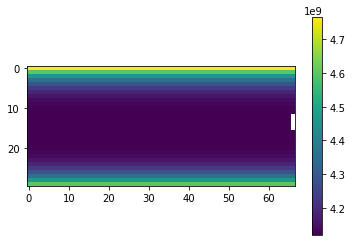

In [45]:
plt.imshow(areacello_nino3[0])
plt.colorbar()

In [46]:
#TODO 
#CALCULATE total_areacello, summation across lat,lon (in our dataset y,x respectively)

total_areacello = areacello_nino3.sum(dim=('x', 'y'))


NINO3 INDEX CALCULATION 

REGION 

(5S-5N , 150W-90W) 

SELECT tos and areacello for the region of interest

## Historical

In [35]:
ds_hist = dict_Omon_tos["CMIP6.CNRM-CERFACS.CNRM-CM6-1.historical.Omon"]


In [36]:
ds_hist.coords

Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon        (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f2'

In [28]:
tm_his_st, tm_his_nd = "1980", "2011"
tm_his_st, tm_his_nd

('1980', '2011')

In [25]:
ds_hist.time.to_dataframe()

,time
time,
1850-01-16 12:00:00,1850-01-16 12:00:00
1850-02-15 00:00:00,1850-02-15 00:00:00
1850-03-16 12:00:00,1850-03-16 12:00:00
1850-04-16 00:00:00,1850-04-16 00:00:00
1850-05-16 12:00:00,1850-05-16 12:00:00
...,...
2014-08-16 12:00:00,2014-08-16 12:00:00
2014-09-16 00:00:00,2014-09-16 00:00:00
2014-10-16 12:00:00,2014-10-16 12:00:00


In [137]:
#ds_hist.time.to_dataframe()

In [29]:
tos_his = ds_hist.tos.sel(time = slice(tm_his_st, tm_his_nd))


In [47]:
#TODO INSERT CORRECT CODE TO SELECT SPECIFIED REGION (lat range and lon range) in TOS 
#tos = ds.tos......
tos_his = ds_hist.tos.sel(y = slice(j,l), x = slice(i,k), time = slice(tm_his_st, tm_his_nd))
tos_his

<xarray.DataArray 'tos' (member_id: 1, time: 384, y: 30, x: 67)>
dask.array<getitem, shape=(1, 384, 30, 67), dtype=float32, chunksize=(1, 1, 30, 67), chunktype=numpy.ndarray>
Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(30, 67), meta=np.ndarray>
    lon        (y, x) float64 dask.array<chunksize=(30, 67), meta=np.ndarray>
  * time       (time) datetime64[ns] 1980-01-16T12:00:00 ... 2011-12-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f2'
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_surface_temperature
    long_name:           Sea Surface Temperature
    units:               degC
    online_operation:    average
    cell_methods:        area: mean where sea time: mean
    interval_operation:  1800 s
    interval_write:      1 month
    description:         This may differ from "surface temperature" in region...
    history:             none
    cell_measures:       area: areacello

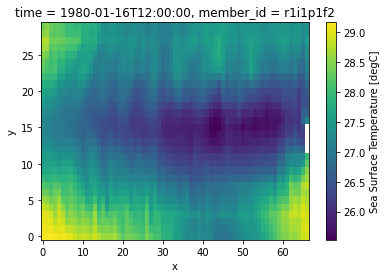

In [49]:
tos_his.isel(time=0).plot()


CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [50]:
areacello_nino3

<xarray.DataArray 'areacello' (member_id: 1, y: 30, x: 67)>
dask.array<getitem, shape=(1, 30, 67), dtype=float32, chunksize=(1, 30, 67), chunktype=numpy.ndarray>
Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(30, 67), meta=np.ndarray>
    lon        (y, x) float64 dask.array<chunksize=(30, 67), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f2'
Dimensions without coordinates: y, x
Attributes:
    standard_name:     cell_area
    long_name:         Grid-Cell Area
    units:             m2
    online_operation:  once
    cell_methods:      area: sum
    description:       Cell areas for any grid used to report ocean variables...
    history:           none

In [51]:
tos_mean_nino3_his = (tos_his * areacello_nino3).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [52]:
tos_mean_nino3_his.compute()

<xarray.DataArray (member_id: 1, time: 384)>
array([[27.147537, 26.883842, 27.10472 , 28.387712, 28.010752, 26.236176,
        25.336542, 24.864368, 24.55669 , 24.465254, 25.078434, 25.993406,
        25.485064, 24.971203, 25.382637, 25.586008, 25.02103 , 23.750347,
        23.284716, 22.916157, 23.60089 , 24.600231, 24.902342, 25.483173,
        26.465818, 26.61591 , 26.933756, 27.164707, 26.020933, 24.45756 ,
        23.648941, 23.137405, 22.387884, 22.118269, 22.204638, 22.458002,
        22.398228, 22.927717, 24.840467, 25.453903, 24.716127, 23.98471 ,
        23.073809, 22.83541 , 23.143833, 23.634686, 24.108826, 24.773123,
        25.236923, 25.173887, 26.049486, 25.79834 , 25.712473, 25.248257,
        24.981356, 24.758873, 24.66728 , 25.143969, 25.593931, 26.011248,
        26.526108, 25.829027, 26.303783, 27.446089, 27.07508 , 25.86154 ,
        25.169823, 24.613424, 24.248941, 24.557753, 25.210297, 25.633326,
        26.228947, 26.500225, 26.975931, 27.485317, 27.928026, 25.91041 ,
        25.479294, 25.258013, 25.216541, 25.197182, 25.313416, 25.93406 ,
        26.354809, 26.366556, 26.895044, 27.363983, 27.913866, 26.499914,
        25.214539, 24.892683, 24.633091, 25.008373, 25.569904, 25.872618,
        26.542952, 26.412462, 27.346731, 28.189997, 26.41754 , 25.150099,
        23.81466 , 23.100761, 22.388584, 22.58783 , 23.154886, 23.683884,
        24.40962 , 25.321426, 26.349323, 26.747345, 26.482405, 25.423447,
        24.792522, 24.047878, 24.354137, 25.42206 , 25.695772, 26.439909,
...
        24.170301, 23.539036, 23.733418, 23.994822, 24.381348, 24.969908,
        25.677666, 26.525644, 26.555662, 27.817122, 27.612427, 26.199928,
        25.687948, 25.08133 , 25.286116, 25.46453 , 25.756296, 26.521406,
        26.370039, 26.163738, 26.112577, 26.599726, 25.746714, 23.374155,
        22.55362 , 22.005377, 21.947945, 22.45624 , 22.793934, 22.865856,
        23.280632, 24.020813, 25.036098, 25.405699, 24.742924, 24.153563,
        24.020327, 23.731415, 23.778969, 24.32318 , 24.655062, 24.979849,
        25.305708, 25.174873, 26.35548 , 27.024567, 27.475996, 26.771633,
        26.349869, 25.512644, 25.51624 , 25.533745, 25.808603, 26.690786,
        27.312607, 28.071962, 28.434624, 28.528677, 29.054613, 27.182482,
        25.554893, 24.462275, 23.980064, 23.883333, 25.282043, 25.556597,
        26.285833, 25.73375 , 26.164871, 26.989475, 26.579317, 25.629444,
        24.393772, 23.525478, 23.34639 , 23.830698, 24.049318, 24.611002,
        25.713453, 25.52526 , 27.38268 , 27.613243, 26.802164, 25.775595,
        25.022114, 24.983656, 24.685305, 25.283682, 25.473404, 26.248621,
        26.605919, 27.26421 , 28.313824, 28.74986 , 28.188793, 26.798853,
        25.173176, 24.553204, 24.002821, 23.82405 , 23.833427, 24.20151 ,
        24.639761, 24.19706 , 24.316496, 25.354088, 26.13455 , 25.21024 ,
        25.094532, 24.5814  , 24.994581, 25.441095, 26.263336, 26.802412]],
      dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-16T12:00:00 ... 2011-12-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f2'

In [53]:
tos_mean_nino3_his.size #1980 values, 1 value per month , 12 per year for 165 years

384

In [54]:
tos_mean_nino3_his.isel(time=0).compute()

<xarray.DataArray (member_id: 1)>
array([27.147537], dtype=float32)
Coordinates:
    time       datetime64[ns] 1980-01-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f2'

In [55]:
datetimeindex = tos_mean_nino3_his.indexes['time'].to_datetimeindex()
tos_mean_nino3_his['time'] = datetimeindex


AttributeError: 'DatetimeIndex' object has no attribute 'to_datetimeindex'

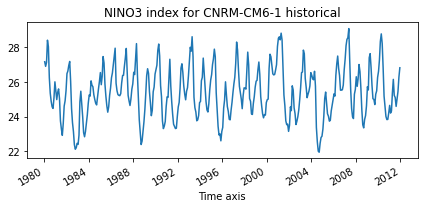

In [58]:
tos_mean_nino3_his.sel(time = slice(tm_his_st, tm_his_nd)).plot(aspect=2, size=3)
plt.title(f"NINO3 index for {model_name} historical")
plt.tight_layout()
plt.draw()

ADDITIONAL EXPLORATION

CLIMATOLOGY (average all Jans, Febs, etc) CALC EXAMPLES (YEARS NEED A TWEAK, calculate for 20 year chunks or as needed)

In [59]:
tos_nino3_climatology = tos_his.sel(time=slice(tm_his_st, tm_his_nd)).groupby('time.month').mean(dim='time')


In [60]:
tos_nino3_climatology.compute()

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tos' (member_id: 1, month: 12, y: 30, x: 67)>
array([[[[27.488459, 27.481106, 27.303696, ..., 28.032972, 28.145363,
          28.192774],
         [27.253056, 27.195967, 27.065025, ..., 28.016914, 28.14328 ,
          28.169315],
         [27.015137, 26.922691, 26.829678, ..., 28.02296 , 28.165155,
          28.155085],
         ...,
         [26.658321, 26.60641 , 26.620396, ..., 26.13063 , 26.372978,
          26.774715],
         [26.732462, 26.716656, 26.681856, ..., 26.134033, 26.381737,
          26.60252 ],
         [26.898792, 26.903866, 26.850882, ..., 26.174597, 26.397633,
          26.53184 ]],

        [[27.994198, 27.920708, 27.88429 , ..., 28.369667, 28.44941 ,
          28.414724],
         [27.721823, 27.686409, 27.690805, ..., 28.34947 , 28.46725 ,
          28.426216],
         [27.473177, 27.461006, 27.46537 , ..., 28.32032 , 28.465977,
          28.411198],
...
         [27.012215, 26.97932 , 26.847473, ..., 26.744429, 26.909264,
          26.84119 ],
         [27.214798, 27.225822, 27.042973, ..., 26.834743, 27.067976,
          26.821213],
         [27.503626, 27.561287, 27.363094, ..., 26.866756, 27.096512,
          26.858635]],

        [[27.409166, 27.417664, 27.275743, ..., 26.474434, 26.43092 ,
          26.646744],
         [27.21121 , 27.140415, 27.02601 , ..., 26.426435, 26.40734 ,
          26.622726],
         [26.992794, 26.874172, 26.795645, ..., 26.41008 , 26.439312,
          26.626888],
         ...,
         [26.853565, 26.745953, 26.774696, ..., 27.216612, 27.259089,
          27.420574],
         [26.990543, 26.942766, 26.914856, ..., 27.211637, 27.31752 ,
          27.23359 ],
         [27.220516, 27.209023, 27.173597, ..., 27.178879, 27.30223 ,
          27.114172]]]], dtype=float32)
Coordinates:
    lat        (y, x) float64 -5.149 -5.149 -5.149 -5.149 ... 4.769 4.769 4.769
    lon        (y, x) float64 -157.5 -156.5 -155.5 -154.5 ... -93.5 -92.5 -91.5
  * member_id  (member_id) <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x

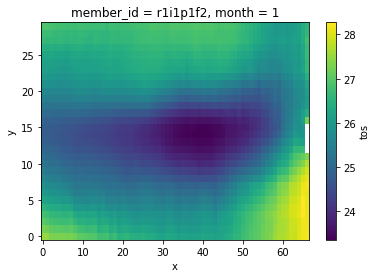

In [61]:
tos_nino3_climatology.isel(month=0).plot()

monthly anomaly of SST (or TOS here) over the Nino3 region

we subtract the monthly climatology values calculated above from the TOS value values and then do
a spatial average across the region of interest

In [62]:
tos_sel = tos_his.sel(time=slice(tm_his_st, tm_his_nd))
index_nino3 = (tos_sel.groupby('time.month')-tos_nino3_climatology).mean(dim=['x','y'])

In [63]:
index_nino3.compute()

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tos' (member_id: 1, time: 384)>
array([[ 1.50738358e+00,  1.00926900e+00,  5.86826384e-01,
         1.18235803e+00,  1.24769878e+00,  7.11854815e-01,
         5.52987874e-01,  6.24469757e-01,  4.88472372e-01,
         1.33447751e-01,  3.97416025e-01,  7.67700434e-01,
        -1.74593866e-01, -9.21350718e-01, -1.14469600e+00,
        -1.65460670e+00, -1.79339230e+00, -1.79075468e+00,
        -1.50017989e+00, -1.32685053e+00, -4.66391712e-01,
         2.77642876e-01,  2.23140925e-01,  2.55982012e-01,
         8.28324854e-01,  7.46113241e-01,  4.16209608e-01,
        -5.60873672e-02, -7.80565083e-01, -1.07377815e+00,
        -1.12781382e+00, -1.09941101e+00, -1.68760729e+00,
        -2.22068214e+00, -2.49027181e+00, -2.78840780e+00,
        -3.27176380e+00, -2.96454954e+00, -1.67942131e+00,
        -1.77720833e+00, -2.08857203e+00, -1.54125845e+00,
        -1.70397913e+00, -1.39904511e+00, -9.17864442e-01,
        -6.84488773e-01, -5.66401243e-01, -4.50962871e-01,
        -4.08728004e-01, -7.08467722e-01, -4.62262928e-01,
        -1.43487585e+00, -1.07983005e+00, -2.64726579e-01,
         2.14012057e-01,  5.28815806e-01,  6.04719043e-01,
         8.25056791e-01,  9.17214334e-01,  7.86294580e-01,
...
         1.68459499e+00,  2.21853876e+00,  1.92978501e+00,
         1.31056857e+00,  2.29555225e+00,  1.67617321e+00,
         7.79207647e-01,  2.19091535e-01, -9.18116942e-02,
        -4.48145568e-01,  6.08379900e-01,  3.27104509e-01,
         6.44261003e-01, -1.54152468e-01, -3.60684067e-01,
        -2.32908905e-01, -2.08600521e-01,  1.07674807e-01,
        -3.86492729e-01, -7.21176326e-01, -7.26036489e-01,
        -4.94588315e-01, -6.31267190e-01, -6.19387746e-01,
         7.32700154e-02, -3.55798393e-01,  8.77437949e-01,
         3.97942632e-01,  1.17164645e-02,  2.60064900e-01,
         2.52171576e-01,  7.56223738e-01,  6.20262802e-01,
         9.64310586e-01,  7.93508410e-01,  1.02697647e+00,
         9.62436497e-01,  1.39616334e+00,  1.81086648e+00,
         1.54012084e+00,  1.41869056e+00,  1.28819871e+00,
         3.92880082e-01,  3.16450506e-01, -6.55598715e-02,
        -5.07722735e-01, -8.56782019e-01, -1.03736293e+00,
        -1.01869822e+00, -1.70019698e+00, -2.22614098e+00,
        -1.88403130e+00, -6.56292975e-01, -3.15675408e-01,
         3.22250843e-01,  3.44065398e-01,  9.30972338e-01,
         1.12169838e+00,  1.59284055e+00,  1.57887304e+00]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-16T12:00:00 ... 2011-12-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f2'
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

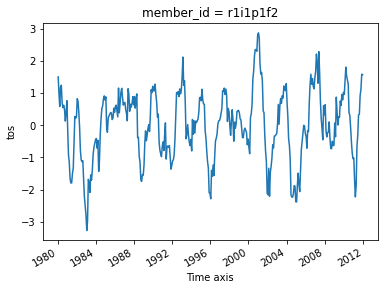

In [64]:
#datetimeindex = index_nino3.indexes['time'].to_datetimeindex()
#index_nino3['time'] = datetimeindex
index_nino3.plot()
plt.savefig(f"{model_name}_Historical_{tm_his_st}_{tm_his_nd}.png", dpi=150)

## 1%CO2

In [32]:
ds_1pct = dict_Omon_tos["CMIP6.NOAA-GFDL.GFDL-ESM4.1pctCO2.Omon"]

In [33]:
ds_1pct.time.to_dataframe()

,time
time,
0001-01-16 12:00:00,0001-01-16 12:00:00
0001-02-15 00:00:00,0001-02-15 00:00:00
0001-03-16 12:00:00,0001-03-16 12:00:00
0001-04-16 00:00:00,0001-04-16 00:00:00
0001-05-16 12:00:00,0001-05-16 12:00:00
...,...
0150-08-16 12:00:00,0150-08-16 12:00:00
0150-09-16 00:00:00,0150-09-16 00:00:00
0150-10-16 12:00:00,0150-10-16 12:00:00


In [ ]:
#ds_1pct.info


In [20]:
#tos_1pct = ds_1pct.tos#.sel(time = slice("1980", "2011"))

In [34]:
#TODO INSERT CORRECT CODE TO SELECT SPECIFIED REGION (lat range and lon range) in TOS 

tos_1pct = ds_1pct.tos.sel(y = slice(-5,5), x = slice(-150,-90))
#tos

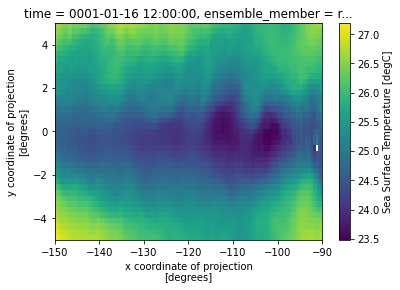

In [35]:
tos_1pct.isel(time=0).plot()

CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [36]:
tos_mean_nino3_1pct = (tos_1pct * areacello_nino3).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [37]:
tos_mean_nino3_1pct.compute()

<xarray.DataArray (ensemble_member: 1, time: 1800)>
array([[25.240553, 25.748297, 26.135637, ..., 27.92831 , 28.12126 ,
        28.985657]], dtype=float32)
Coordinates:
  * time             (time) object 0001-01-16 12:00:00 ... 0150-12-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [38]:
tos_mean_nino3_1pct.size

1800

In [39]:
tos_mean_nino3_1pct.isel(time=0).compute()

<xarray.DataArray (ensemble_member: 1)>
array([25.240553], dtype=float32)
Coordinates:
    time             object 0001-01-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [40]:
#datetimeindex_1pct = tos_mean_nino3_1pct.indexes['time'].to_datetimeindex()

In [41]:
#tos_mean_nino3_1pct['time'] = datetimeindex_1pct

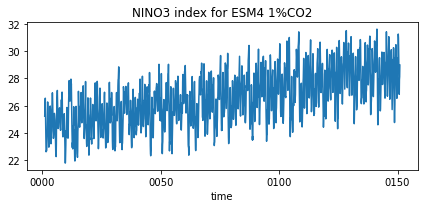

In [42]:
tos_mean_nino3_1pct.plot(aspect=2, size=3)
plt.title("NINO3 index for ESM4 1%CO2")
plt.tight_layout()
plt.draw()

In [43]:
tos_nino3_climatology_1pct = tos_1pct.sel(time=slice('0119','0150')).groupby('time.month').mean(dim='time')


In [44]:
tos_nino3_climatology_1pct.compute()

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tos' (ensemble_member: 1, month: 12, y: 39, x: 120)>
array([[[[30.213112, 30.188995, 30.1706  , ..., 29.830112, 29.852398,
          29.880331],
         [30.17844 , 30.152851, 30.136745, ..., 29.842587, 29.863445,
          29.887173],
         [30.136904, 30.104893, 30.091488, ..., 29.851913, 29.86638 ,
          29.886084],
         ...,
         [29.589394, 29.584965, 29.576187, ..., 29.719463, 29.811716,
          29.888096],
         [29.638636, 29.631884, 29.618332, ..., 29.712002, 29.81858 ,
          29.911   ],
         [29.680494, 29.672598, 29.662003, ..., 29.687664, 29.81202 ,
          29.919664]],

        [[30.676498, 30.66817 , 30.655128, ..., 30.525711, 30.507595,
          30.491983],
         [30.614304, 30.60513 , 30.58675 , ..., 30.50057 , 30.467339,
          30.447266],
         [30.538797, 30.530914, 30.518574, ..., 30.438341, 30.40107 ,
          30.376741],
...
         [29.544744, 29.53453 , 29.50552 , ..., 30.165003, 30.139393,
          30.10944 ],
         [29.634571, 29.615286, 29.59287 , ..., 30.202045, 30.17641 ,
          30.1494  ],
         [29.734144, 29.716854, 29.695312, ..., 30.223364, 30.201542,
          30.186283]],

        [[29.6629  , 29.649364, 29.6409  , ..., 27.941244, 27.945028,
          27.946358],
         [29.628082, 29.61208 , 29.59947 , ..., 27.912395, 27.917028,
          27.923817],
         [29.5962  , 29.581236, 29.560741, ..., 27.876083, 27.887657,
          27.897982],
         ...,
         [29.644798, 29.61794 , 29.590204, ..., 29.97118 , 30.009048,
          30.051731],
         [29.711823, 29.680387, 29.655628, ..., 29.95771 , 30.007977,
          30.058826],
         [29.765667, 29.735834, 29.713638, ..., 29.922577, 29.986296,
          30.047022]]]], dtype=float32)
Coordinates:
    lat              (y, x) float32 -4.872 -4.872 -4.872 ... 4.872 4.872 4.872
    lon              (y, x) float32 -149.8 -149.2 -148.8 ... -90.75 -90.25
  * x                (x) float64 -149.8 -149.2 -148.8 ... -91.25 -90.75 -90.25
  * y                (y) float64 -4.872 -4.615 -4.359 ... 4.359 4.615 4.872
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

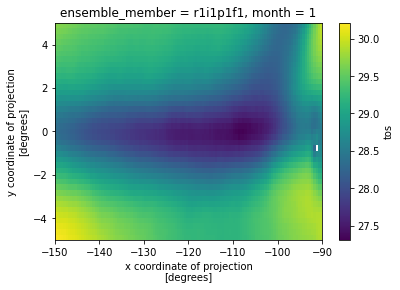

In [45]:
tos_nino3_climatology_1pct.isel(month=0).plot()

monthly anomaly of SST (or TOS here) over the Nino3 region

we subtract the monthly climatology values calculated above from the TOS value values and then do
a spatial average across the region of interest

In [46]:
tos_sel = tos_1pct.sel(time=slice('0119','0150'))
index_nino3 = (tos_sel.groupby('time.month')-tos_nino3_climatology_1pct).mean(dim=['x','y'])

In [47]:
index_nino3.compute()

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tos' (ensemble_member: 1, time: 384)>
array([[-2.4369519 , -2.2268212 , -1.0887513 , -1.6543334 , -1.5035197 ,
        -1.2875879 , -1.0684881 , -1.4005944 , -1.2731    , -1.3996809 ,
        -1.58933   , -1.5726931 , -1.2612725 , -0.6119959 , -0.51061875,
        -0.13067307, -0.29454368, -0.04160992, -0.17284419, -0.26489195,
         0.02869011,  0.4207879 ,  0.02471487, -0.04387553, -0.07532196,
        -0.19544934, -0.26992562, -0.8190028 , -0.30284485, -0.6764676 ,
        -0.6333329 , -0.01547616,  0.16490395, -0.28924665, -0.644857  ,
        -0.14059876, -0.39786774, -0.26563781, -0.53002644, -0.5272849 ,
         0.02802673,  0.98940456,  1.3593884 ,  0.9912849 ,  0.66672784,
         0.670518  ,  0.30287465, -0.25085023, -0.26936194, -0.45564312,
        -0.80144507, -0.38800552, -0.9126912 , -1.1749899 , -1.3568214 ,
        -1.1087555 , -1.4447093 , -0.64234054, -0.5694114 , -0.77251536,
        -0.32780448, -0.8955987 , -0.01791439,  0.02088269, -0.28242624,
        -0.93562704, -1.3307865 , -1.9477749 , -1.9943852 , -1.7336345 ,
        -2.2079718 , -1.6415415 , -0.68658674, -0.3762771 ,  0.16121095,
         0.091989  ,  0.7316947 ,  1.1050764 ,  0.9559299 ,  0.6947481 ,
         0.6008345 ,  0.18342237, -0.06635599, -0.5096147 , -0.6080536 ,
        -1.1362656 , -1.2539004 , -0.6717468 , -1.4990873 , -1.2803187 ,
        -0.61892086, -0.31274074, -0.18638737, -0.02652749,  0.4875758 ,
         0.6004967 ,  0.2831006 ,  0.27150095,  0.58753574,  0.36027732,
...
        -0.5345194 , -0.53313386, -0.11180329,  0.26588023,  0.3369079 ,
         0.82470024,  1.2793261 ,  1.2823577 ,  0.91595846,  0.5875596 ,
         0.38317513,  0.21429671, -0.31416753, -0.35331574, -0.46565187,
        -0.8663356 , -0.64976525, -0.03015177,  0.24542378,  0.1765754 ,
         0.32983452,  0.50830954,  0.43352586,  0.35982594,  0.9267963 ,
         1.157785  ,  0.6227679 ,  0.6827985 ,  0.75364524,  0.62893903,
         0.38742086,  0.3754449 ,  0.32459682,  0.33483157,  0.20203443,
         0.9881769 ,  0.9853196 ,  0.7987803 ,  0.51569223,  0.95085263,
         0.9769161 ,  0.82514256,  0.1648155 , -0.13554479,  0.08262371,
        -0.27564645,  0.07859372,  0.19080994, -0.4583548 , -0.316397  ,
         0.06270322, -0.03229918, -0.11438977, -0.47512197, -0.5908516 ,
        -0.17773159, -0.04202524,  0.08589452,  0.09709202,  0.50927603,
        -0.35982484, -0.00820339,  0.06509932, -0.5364282 , -0.7249427 ,
        -1.2470423 , -1.5404854 , -1.21077   , -1.1435374 , -0.4587622 ,
         0.7545023 ,  0.3829307 ,  0.41256016,  0.2119426 ,  0.28851348,
        -0.11456998, -0.08851116,  0.24047692,  0.23467404,  0.10117027,
         0.38907775,  0.3508126 ,  0.75314975,  0.10327009,  0.20809744,
         0.99135965,  0.91818434,  1.1799519 ,  1.1277878 ,  0.99605316,
         0.5242531 ,  1.2069478 ,  0.84775275,  0.85939485]],
      dtype=float32)
Coordinates:
  * time             (time) object 0119-01-16 12:00:00 ... 0150-12-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
    month            (time) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12

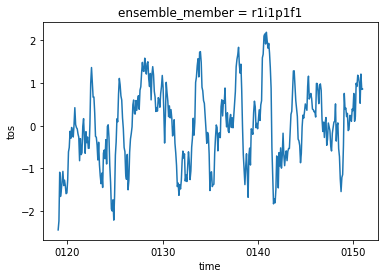

In [48]:
#datetimeindex = index_nino3.indexes['time'].to_datetimeindex()
#index_nino3['time'] = datetimeindex
index_nino3.plot()

## Abrupt-4xCO2

In [49]:
ds_4x = dict_Omon_tos["CMIP6.NOAA-GFDL.GFDL-ESM4.abrupt-4xCO2.Omon"]

In [50]:
ds_4x.time.to_dataframe()

,time
time,
0001-01-16 12:00:00,0001-01-16 12:00:00
0001-02-15 00:00:00,0001-02-15 00:00:00
0001-03-16 12:00:00,0001-03-16 12:00:00
0001-04-16 00:00:00,0001-04-16 00:00:00
0001-05-16 12:00:00,0001-05-16 12:00:00
...,...
0150-08-16 12:00:00,0150-08-16 12:00:00
0150-09-16 00:00:00,0150-09-16 00:00:00
0150-10-16 12:00:00,0150-10-16 12:00:00


In [51]:
tos_4x = ds_4x.tos.sel(time = slice("0119", "0150"))

In [52]:
#TODO INSERT CORRECT CODE TO SELECT SPECIFIED REGION (lat range and lon range) in TOS 
#tos = ds.tos......
tos_4x = ds_4x.tos.sel(y = slice(-5,5), x = slice(-150,-90))
#tos

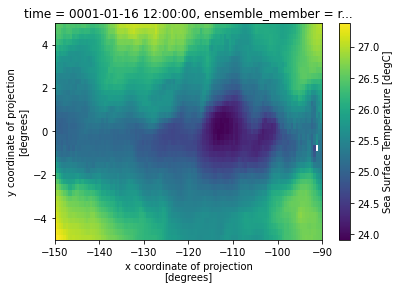

In [53]:
tos_4x.isel(time=0).plot()

CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [54]:
tos_mean_nino3_4x = (tos_4x * areacello_nino3).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [55]:
tos_mean_nino3_4x.compute()

<xarray.DataArray (ensemble_member: 1, time: 1800)>
array([[25.639414, 26.249512, 26.237864, ..., 26.837673, 27.146858,
        28.272776]], dtype=float32)
Coordinates:
  * time             (time) object 0001-01-16 12:00:00 ... 0150-12-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [56]:
tos_mean_nino3_4x.size #1980 values, 1 value per month , 12 per year for 165 years

1800

In [57]:
tos_mean_nino3_4x.isel(time=0).compute()

<xarray.DataArray (ensemble_member: 1)>
array([25.639414], dtype=float32)
Coordinates:
    time             object 0001-01-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'

In [ ]:
#datetimeindex_4x = tos_mean_nino3_4x.indexes['time'].to_datetimeindex()
#tos_mean_nino3_4x['time'] = datetimeindex_4x


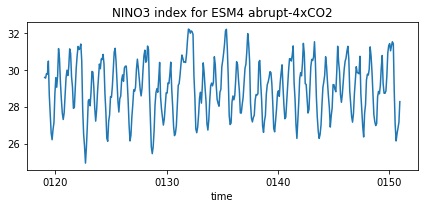

In [58]:
tos_mean_nino3_4x.sel(time=slice('0119','0150')).plot(aspect=2, size=3)
plt.title("NINO3 index for ESM4 abrupt-4xCO2")
plt.tight_layout()
plt.draw()

In [59]:
tos_nino3_climatology_4x = tos_4x.sel(time=slice('0119','0150')).groupby('time.month').mean(dim='time')


In [60]:
tos_nino3_climatology_4x.compute()

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tos' (ensemble_member: 1, month: 12, y: 39, x: 120)>
array([[[[31.292557, 31.278255, 31.25933 , ..., 30.644096, 30.643713,
          30.648481],
         [31.262165, 31.247082, 31.23045 , ..., 30.631214, 30.632128,
          30.641008],
         [31.223927, 31.208199, 31.194416, ..., 30.60096 , 30.597363,
          30.609692],
         ...,
         [30.404438, 30.394375, 30.370564, ..., 30.480522, 30.56845 ,
          30.629513],
         [30.432983, 30.422739, 30.402893, ..., 30.480492, 30.58258 ,
          30.657866],
         [30.45979 , 30.443903, 30.426672, ..., 30.460148, 30.580547,
          30.67406 ]],

        [[31.4846  , 31.471094, 31.448944, ..., 31.20119 , 31.179659,
          31.175117],
         [31.426594, 31.418667, 31.396954, ..., 31.15839 , 31.13197 ,
          31.119682],
         [31.36346 , 31.355942, 31.340927, ..., 31.084084, 31.046272,
          31.026888],
...
         [30.380787, 30.356617, 30.330814, ..., 30.964539, 30.95686 ,
          30.941505],
         [30.444231, 30.422375, 30.39529 , ..., 31.003254, 30.9972  ,
          30.989666],
         [30.505922, 30.478863, 30.46952 , ..., 31.028612, 31.025417,
          31.02362 ]],

        [[30.726265, 30.6968  , 30.653913, ..., 29.036196, 29.048416,
          29.065624],
         [30.704536, 30.671574, 30.625748, ..., 29.043663, 29.054554,
          29.070675],
         [30.67921 , 30.644247, 30.597025, ..., 29.04681 , 29.058304,
          29.070923],
         ...,
         [30.419155, 30.402534, 30.385689, ..., 30.801256, 30.866055,
          30.927359],
         [30.465225, 30.44743 , 30.42693 , ..., 30.794987, 30.866947,
          30.938206],
         [30.494148, 30.479063, 30.464943, ..., 30.774273, 30.854958,
          30.931442]]]], dtype=float32)
Coordinates:
    lat              (y, x) float32 -4.872 -4.872 -4.872 ... 4.872 4.872 4.872
    lon              (y, x) float32 -149.8 -149.2 -148.8 ... -90.75 -90.25
  * x                (x) float64 -149.8 -149.2 -148.8 ... -91.25 -90.75 -90.25
  * y                (y) float64 -4.872 -4.615 -4.359 ... 4.359 4.615 4.872
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

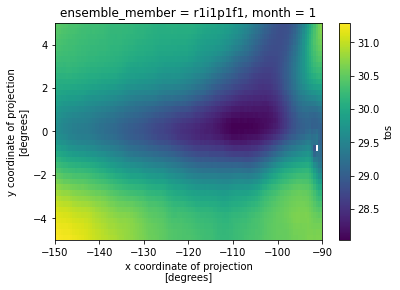

In [61]:
tos_nino3_climatology_4x.isel(month=0).plot()

monthly anomaly of SST (or TOS here) over the Nino3 region

we subtract the monthly climatology values calculated above from the TOS value values and then do
a spatial average across the region of interest

In [63]:
tos_sel_4x = tos_4x.sel(time=slice('0119','0150'))
index_nino3_4x = (tos_sel_4x.groupby('time.month')-tos_nino3_climatology_4x).mean(dim=['x','y'])

In [64]:
index_nino3_4x.compute()

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tos' (ensemble_member: 1, time: 384)>
array([[-8.74107704e-02, -7.37763494e-02, -1.68114826e-01,
        -9.32660699e-01, -2.17863426e-01, -7.36274779e-01,
        -8.40539575e-01, -8.51836205e-01, -8.96704376e-01,
        -8.78183246e-01, -1.18579495e+00, -5.81182539e-01,
        -1.02789253e-01, -5.68892717e-01, -2.74588794e-01,
         4.54435408e-01, -7.96259493e-02, -2.61057951e-02,
         1.87998787e-02,  2.32262492e-01,  1.99139118e-01,
         1.79979168e-02,  3.09440970e-01,  2.62411237e-01,
         3.03553402e-01,  6.61185682e-02,  1.94954619e-01,
         4.38777834e-01,  1.95601434e-01,  2.67179370e-01,
         6.77904606e-01,  4.86059934e-01,  8.56214046e-01,
         1.42374754e+00,  1.75959516e+00,  1.48079729e+00,
         1.59389365e+00,  1.47612572e+00,  1.19431734e+00,
         7.00514853e-01, -2.18954012e-01, -1.45555949e+00,
        -1.85796893e+00, -1.58235073e+00, -2.16341591e+00,
        -1.82947516e+00, -1.35595596e+00, -9.69534159e-01,
        -1.28399885e+00, -1.57496572e+00, -1.18191504e+00,
        -7.82840908e-01, -8.13470483e-01, -2.88691789e-01,
        -4.58004832e-01, -2.07408965e-01,  7.00237393e-01,
         1.16341758e+00,  1.20208585e+00,  1.02664578e+00,
...
         7.93646455e-01,  1.01535559e+00,  1.05352962e+00,
         5.77390313e-01, -1.04310855e-01, -4.78857070e-01,
        -2.39050150e-01,  4.16967273e-02,  5.61336428e-02,
        -1.58183333e-02,  3.81858885e-01,  1.87509343e-01,
         4.93376940e-01,  2.22453773e-01, -1.25813767e-01,
        -9.11167860e-01,  4.14678045e-02, -6.66726053e-01,
        -5.89962423e-01, -5.09880781e-01, -7.46467471e-01,
        -1.03685278e-02, -2.06337273e-01,  1.62042856e-01,
         8.93069059e-02,  9.28855538e-02,  5.76153100e-02,
         5.46023250e-01,  5.97724356e-02,  5.32845736e-01,
         3.94871414e-01,  1.41908601e-01,  7.96953216e-02,
        -6.70938611e-01, -1.23742771e+00, -7.48939633e-01,
        -8.42359841e-01, -9.23137903e-01, -8.14461946e-01,
        -5.88853359e-01,  8.57213363e-02, -8.58114660e-02,
         3.39618146e-01,  1.30093241e+00,  1.74823010e+00,
         2.01924944e+00,  2.59080982e+00,  2.02930427e+00,
         1.74860919e+00,  1.40566576e+00,  1.33391166e+00,
         8.23190033e-01,  7.20793188e-01, -5.24922609e-01,
        -1.37420654e+00, -1.27991092e+00, -5.71609557e-01,
        -8.06556165e-01, -1.17358994e+00, -1.00822163e+00]], dtype=float32)
Coordinates:
  * time             (time) object 0119-01-16 12:00:00 ... 0150-12-16 12:00:00
  * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
    month            (time) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12

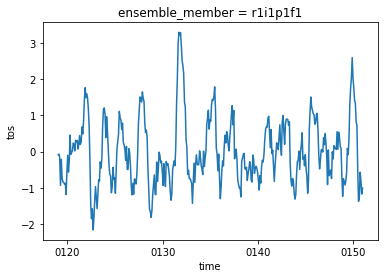

In [65]:
#datetimeindex = index_nino3.indexes['time'].to_datetimeindex()
#index_nino3['time'] = datetimeindex
index_nino3_4x.plot()